In [ ]:
# Install and import required libraries
!pip install tensorflow keras pillow scikit-learn flask
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, Reshape, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Mount Google Drive and download dataset
from google.colab import drive
drive.mount('/content/drive')
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d /content/drive/MyDrive/MRI_Images
!rm -f brain-tumor-mri-dataset.zip
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/brain_tumor_mri_dataset/Training"
test_dir  = "/content/drive/MyDrive/brain_tumor_mri_dataset/Testing"

import os

print("Train classes:", os.listdir(train_dir))
for cls in os.listdir(train_dir):
    print(cls, "→", len(os.listdir(os.path.join(train_dir, cls))), "images")

print("\nTest classes:", os.listdir(test_dir))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
Archive:  brain-tumor-mri-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a mult

5743 train images
1347 test images
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Label mapping: {np.str_('glioma'): np.int64(0), np.str_('meningioma'): np.int64(1), np.str_('notumor'): np.int64(2), np.str_('pituitary'): np.int64(3)}


Batch shape: (32, 128, 128, 3)


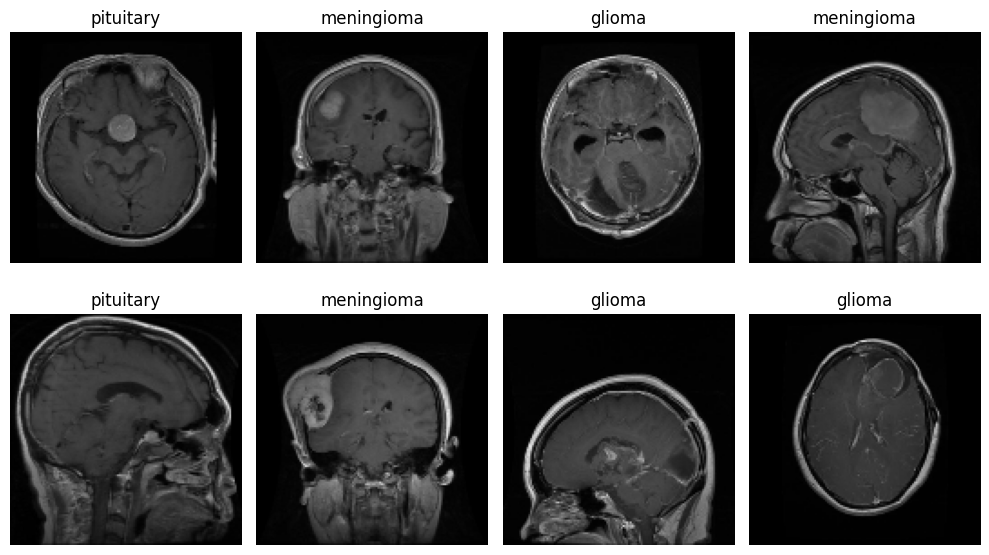

In [ ]:
train_dir = "/content/drive/MyDrive/brain_tumor_mri_dataset/Training"
test_dir  = "/content/drive/MyDrive/brain_tumor_mri_dataset/Testing"
IMG_SIZE = 128
BATCH_SIZE = 32
import os
import numpy as np

def load_paths_and_labels(base_dir):
    paths, labels = [], []
    classes = sorted(os.listdir(base_dir))  # ensures fixed order
    for cls in classes:
        cls_folder = os.path.join(base_dir, cls)
        if not os.path.isdir(cls_folder):
            continue
        for fname in os.listdir(cls_folder):
            if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(os.path.join(cls_folder, fname))
                labels.append(cls)
    return paths, labels

train_paths, train_labels = load_paths_and_labels(train_dir)
test_paths, test_labels   = load_paths_and_labels(test_dir)

print(len(train_paths), "train images")
print(len(test_paths), "test images")
print("Classes:", sorted(set(train_labels)))
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc  = le.transform(test_labels)

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

def safe_read_image(path):
    try:
        img = plt.imread(path)
        img = np.array(img)
        if img.ndim == 2:              # grayscale → RGB
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[2] == 4:  # RGBA → RGB
            img = img[..., :3]
        return img
    except Exception as e:
        print("Bad image, skipping:", path, "| error:", e)
        return None

def data_generator(paths, labels, batch_size, augment=False):
    num_samples = len(paths)
    while True:
        idx = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images, batch_labels = [], []
            for j in batch_idx:
                img = safe_read_image(paths[j])
                if img is None:
                    continue  # skip bad file

                img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img.numpy()

                if augment:
                    img = tf.image.random_flip_left_right(img)
                    img = tf.image.random_brightness(img, 0.1)

                batch_images.append(img/255.0)
                batch_labels.append(labels[j])

            if len(batch_images) == 0:
                continue  # in case all in this batch were bad

            yield np.array(batch_images), np.array(batch_labels)
train_gen = data_generator(train_paths, train_labels_enc, BATCH_SIZE, augment=True)
val_gen   = data_generator(train_paths, train_labels_enc, BATCH_SIZE, augment=False)

images, labels = next(train_gen)
print("Batch shape:", images.shape)

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i])
    plt.title(le.inverse_transform([labels[i]])[0])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# ===================== STEP 3: BUILD CRNN MODEL =========================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Dropout,
                                     LSTM, Reshape, Bidirectional)

# CNN + BiLSTM model for 4‑class brain tumor classification
model = Sequential([
    # ---- CNN feature extractor ----
    Conv2D(32, (3,3), activation='relu', padding='same',
           input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    # Now feature map ≈ 16x16x128 for IMG_SIZE=128

    # ---- reshape to (timesteps, features) for RNN ----
    # 16x16 = 256; choose 32 timesteps -> each timestep sees 8 spatial units
    Reshape((32, 128 * 8)),   # (batch, 32, 1024)

    # ---- RNN layers ----
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),

    # ---- Dense classifier ----
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')   # 4 classes: glioma, meningioma, notumor, pituitary
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
print("✅ STEP 3 COMPLETE: Model built and compiled")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │       557,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,868 (2.67 MB)

 Trainable params: 700,868 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

✅ STEP 3 COMPLETE: Model built and compiled


Steps per epoch: 179
Validation steps: 35
Epoch 1/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.9994 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 7.3975e-04
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.9919 - loss: 0.0277 - val_accuracy: 0.9982 - val_loss: 0.0081
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9961 - loss: 0.0096 - val_accuracy: 0.9991 - val_loss: 0.0052
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.9873 - loss: 0.0382 - val_accuracy: 0.9920 - val_loss: 0.0313
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 0.9900 - loss: 0.0244 - val_accuracy: 0.9991 - val_loss: 0.0017
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.9990 - loss: 0.0048 - val_accuracy: 0.9946 - val_loss: 0.0209
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9925 - loss: 0.0248 - val_accuracy: 0.9937 - val_loss: 0.0135
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/ste

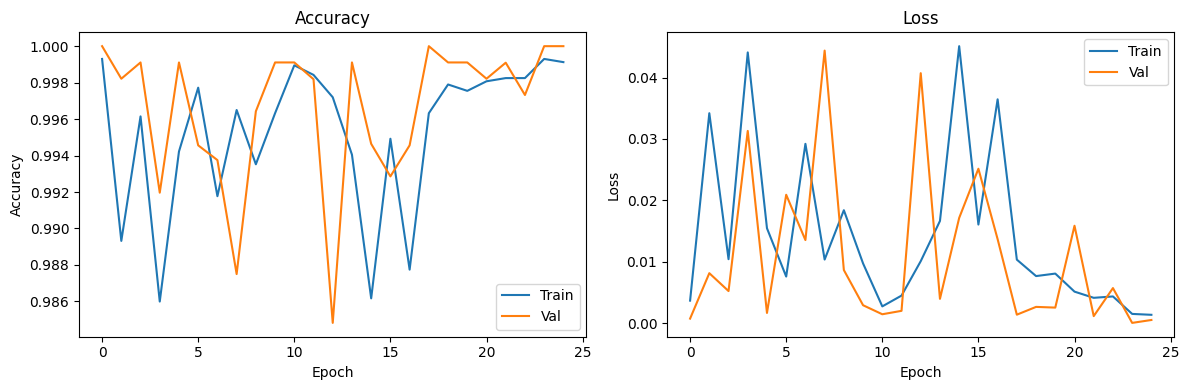

✅ STEP 4 COMPLETE: Training finished


In [ ]:
# ===================== STEP 4: TRAIN THE CRNN MODEL =====================
# (Run this AFTER Step 3, with train_gen, val_gen, train_paths defined)

import math

EPOCHS = 25   # you can increase later if needed

steps_per_epoch = len(train_paths) // BATCH_SIZE
val_steps       = max(1, len(train_paths) // (BATCH_SIZE * 5))

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", val_steps)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=EPOCHS,
    verbose=1
)

# ---- plot training curves ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("✅ STEP 4 COMPLETE: Training finished")


Test images shape: (1347, 128, 128, 3)
Test labels shape: (1347,)
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 401ms/step

=== Classification Report (TEST) ===

              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       300
  meningioma       0.97      0.97      0.97       336
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.99      0.99       306

    accuracy                           0.99      1347
   macro avg       0.99      0.98      0.98      1347
weighted avg       0.99      0.99      0.99      1347



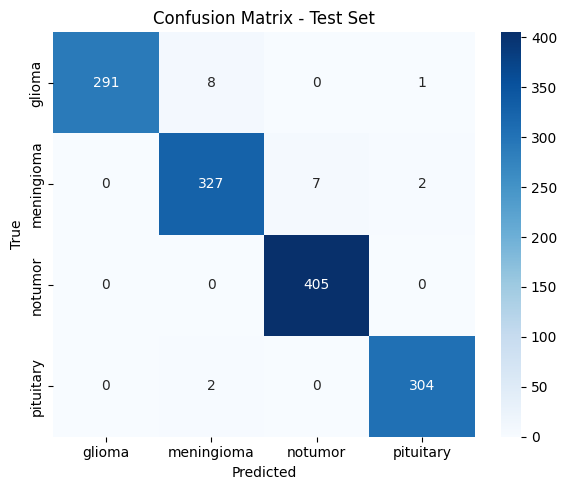

✅ STEP 5 COMPLETE: Model saved to /content/drive/MyDrive/brain_tumor_crnn.h5


In [ ]:
# ===================== STEP 5: TEST EVALUATION + SAVE ====================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# ---- 5.1 build full test array (using safe_read_image from before) ----
all_test_imgs = []
valid_test_labels = []

for p, lbl in zip(test_paths, test_labels_enc):
    img = safe_read_image(p)    # function defined earlier
    if img is None:
        continue
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)).numpy() / 255.0
    all_test_imgs.append(img)
    valid_test_labels.append(lbl)

all_test_imgs = np.array(all_test_imgs)
valid_test_labels = np.array(valid_test_labels)

print("Test images shape:", all_test_imgs.shape)
print("Test labels shape:", valid_test_labels.shape)

# ---- 5.2 predict on test set ----
pred_probs   = model.predict(all_test_imgs, batch_size=BATCH_SIZE)
pred_classes = np.argmax(pred_probs, axis=1)

# ---- 5.3 classification report ----
print("\n=== Classification Report (TEST) ===\n")
print(classification_report(valid_test_labels,
                            pred_classes,
                            target_names=le.classes_))

# ---- 5.4 confusion matrix ----
cm = confusion_matrix(valid_test_labels, pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

# ---- 5.5 save model to Drive ----
save_path = "/content/drive/MyDrive/brain_tumor_crnn.h5"
model.save(save_path)
print("✅ STEP 5 COMPLETE: Model saved to", save_path)


In [ ]:
!pip install flask-ngrok


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

for root, dirs, files in os.walk('/content/drive/MyDrive'):
    for f in files:
        if f.endswith('.h5'):
            print(os.path.join(root, f))


Mounted at /content/drive
/content/drive/MyDrive/brain_tumor_crnn.h5


In [ ]:
%%writefile app.py
from flask import Flask, request, render_template
import tensorflow as tf
import numpy as np
from PIL import Image
import io

MODEL_PATH = "/content/drive/MyDrive/brain_tumor_crnn.h5"
model = tf.keras.models.load_model(MODEL_PATH)
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 128

app = Flask(__name__)

def preprocess_image(file_stream):
    img = Image.open(file_stream).convert("RGB")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype("float32") / 255.0
    return np.expand_dims(arr, axis=0)

@app.route("/", methods=["GET", "POST"])
def index():
    prediction, confidence, error = None, None, None
    if request.method == "POST":
        if "image" not in request.files or request.files["image"].filename == "":
            error = "Please upload an MRI image."
        else:
            file = request.files["image"]
            try:
                img_batch = preprocess_image(file.stream)
                probs = model.predict(img_batch)[0]
                cls_idx = int(np.argmax(probs))
                prediction = CLASSES[cls_idx]
                confidence = f"{probs[cls_idx] * 100:.2f}%"
            except Exception as e:
                error = f"Error: {e}"
    return f"""
    <h1>Brain Tumor Detection (CRNN)</h1>
    <form method="POST" enctype="multipart/form-data">
      <input type="file" name="image" accept="image/*" required>
      <button type="submit">Upload & Detect</button>
    </form>
    <p>{'Prediction: ' + str(prediction) if prediction else ''}</p>
    <p>{'Confidence: ' + str(confidence) if confidence else ''}</p>
    <p style="color:red;">{error if error else ''}</p>
    """


Writing app.py


In [ ]:
# ================== Simple Colab Flask runner (no ngrok) ==================
from google.colab.output import eval_js
from threading import Thread
import socket
import IPython

from app import app

def run_app():
    app.run(host='0.0.0.0', port=5000)

# start Flask in a background thread
thread = Thread(target=run_app)
thread.start()

# show the public URL for this Colab notebook
print("Open this URL in your browser:")
print(eval_js("google.colab.kernel.proxyPort(5000)"))


Exception in thread Thread-5 (run_app):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipython-input-3179027936.py", line 10, in run_app
TypeError: run_with_ngrok.<locals>.new_run() got an unexpected keyword argument 'host'


Open this URL in your browser:
https://5000-m-s-1pmwb3cv4n0xs-b.us-west3-2.prod.colab.dev


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded!
Choose an MRI image from your computer...


Saving Te-me_0165.jpg to Te-me_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


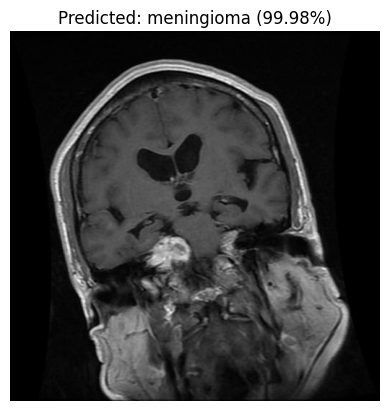

Prediction: meningioma
Confidence: 99.98%


In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = 128

# ---- 1. load model from Drive ----
MODEL_PATH = "/content/drive/MyDrive/brain_tumor_crnn.h5"
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded!")

# ---- 2. upload an MRI image from YOUR PC ----
print("Choose an MRI image from your computer...")
uploaded = files.upload()   # opens file chooser

# take first uploaded file
file_name = list(uploaded.keys())[0]
img_bytes = uploaded[file_name]

# ---- 3. preprocess ----
img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
img_resized = img.resize((IMG_SIZE, IMG_SIZE))
arr = np.array(img_resized).astype("float32") / 255.0
arr = np.expand_dims(arr, axis=0)

# ---- 4. predict ----
probs = model.predict(arr)[0]
pred_idx = int(np.argmax(probs))
pred_class = CLASSES[pred_idx]
confidence = probs[pred_idx] * 100

# ---- 5. show result ----
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {pred_class} ({confidence:.2f}%)")
plt.show()

print("Prediction:", pred_class)
print("Confidence:", f"{confidence:.2f}%")
